In [23]:
# imports and loading
from pymodulon.io import *
from pymodulon.plotting import *
from scipy.stats import fisher_exact, chi2_contingency
from statsmodels.stats.multitest import multipletests
from os import path
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
import squarify  # For treemap plotting
import sys
sys.path.insert(0, '../functions/matplotlib-extra-master/src')
import mpl_extra.treemap as tr

data_dir = path.join('..','data','processed_data')
interim_dir = path.join('..','data','interim')
ica_data = load_json_model(path.join(interim_dir,'zmo_raw.json.gz'))

QC_stats_df = pd.read_csv('../data/interim/metadata_qc_part2_all.tsv', delimiter = '\t')

In [24]:
keep = []
for index, row in ica_data.gene_table.iterrows():
    if 'ZMO0958' in str(row['ZM4_locus']):
        keep.append(index)
ica_data.gene_table.loc[keep]

,gene_name,accession,start,end,strand,gene_product,COG,regulator,uniprot,operon,...,LDI_early_glucose_fold_change,LDI_late_glucose_fold_change,LDI_early_xylose_fold_change,LDI_late_xylose_fold_change,no_LDI_early_glucose_fold_change,no_LDI_late_glucose_fold_change,no_LDI_early_xylose_fold_change,no_LDI_late_xylose_fold_change,chromosome_id,iMs


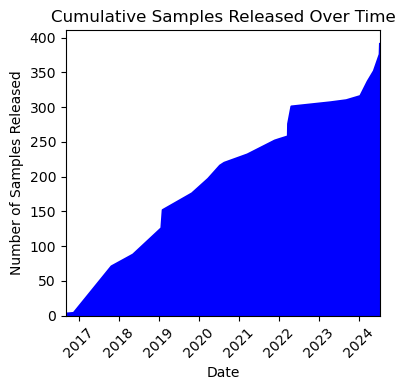

In [55]:
df = pd.read_csv('../data/raw_data/Zymomonas_mobilis.csv', index_col = 0, encoding='ISO-8859-1')

# Ensure 'energy_production_1' is a datetime object
df['run_date'] = pd.to_datetime(df['run_date'], errors='coerce')

# Group by date and count the number of samples
date_counts = df['run_date'].dt.date.value_counts().sort_index()

# Compute the cumulative sum
cumulative_counts = date_counts.sort_index().cumsum()

# Plotting the cumulative counts
plt.figure(figsize=(4, 4))
plt.plot(cumulative_counts.index, cumulative_counts.values, linestyle='-', color='b')
plt.fill_between(cumulative_counts.index, cumulative_counts.values, color='b')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Number of Samples Released')
plt.title('Cumulative Samples Released Over Time')
plt.xticks(rotation=45)
plt.tight_layout()
plt.xlim([cumulative_counts.index.min(), cumulative_counts.index.max()])
plt.ylim([0, cumulative_counts.max() * 1.05])  # Set y-axis limit with a 5% margin on the maximum value

# Show plot
plt.savefig('../figures/released_samples.pdf', transparent = True)
plt.show()

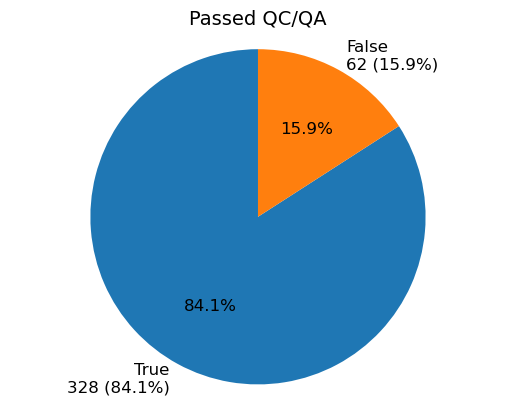

In [26]:
# let's create some summary tables, first pie chart of QC pass/fail
data = dict(QC_stats_df.passed_curation.value_counts())
total = sum(data.values())

# Calculate percentages
percentages = {key: (value / total) * 100 for key, value in data.items()}

# Create the pie chart
fig, ax = plt.subplots()
ax.pie(
    data.values(),
    labels=[f"{key}\n{value} ({percentages[key]:.1f}%)" for key, value in data.items()],
    autopct='%.1f%%', 
    startangle=90, 
    textprops={'fontsize': 12}
)
ax.set_title('Passed QC/QA', fontsize=14)
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.

# Display the chart
plt.show()

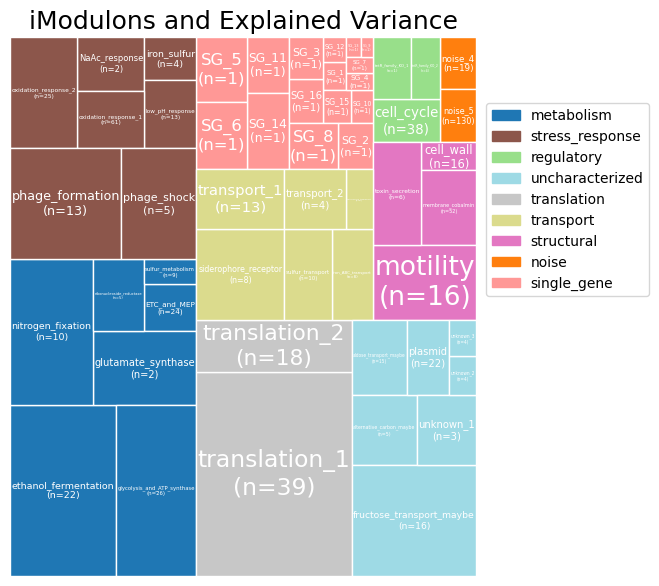

In [28]:
# explained variance treemap plot
df = ica_data.imodulon_table
df['labels'] = [index + '\n(n='+str(size)+')' for (index, size) in zip(df.index, ica_data.imodulon_table.imodulon_size)]
df = df.sort_values(by = 'category')

# Dynamically generate a color palette for unique categories
unique_categories = df['category'].unique()
palette = sns.color_palette('tab20', len(unique_categories))  # 'tab20' gives up to 20 distinct colors
color_map = dict(zip(unique_categories, palette))

# Map colors to categories
colors = df['category'].map(color_map)

# Create the treemap
fig, ax = plt.subplots(figsize=(7,7), dpi=100, subplot_kw=dict(aspect=1.156))
trc = tr.treemap(ax, df, area = 'explained_variance', labels = 'labels',
           cmap='tab20', fill='category', levels = ['category', 'labels'],
           rectprops=dict(ec='w'),
           textprops=dict(c='w'))

# make a legend
handles = sorted(trc.handles['labels'], 
                 key=lambda x: (x.get_ec(),x.get_label()))
legend = fig.legend(handles=[handles[i] for i in range(len(handles))],
          ncol=1, loc='lower left', bbox_to_anchor=(0.85, 0.5))

# Customize the plot
plt.title('iModulons and Explained Variance', fontsize=18)
plt.axis('off')  # Remove axes
plt.savefig('../figures/overall_iM_variance.pdf', transparent = True)
plt.show()